<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/AEvsVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1) ライブラリ
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:
# 2) データ（正常=シャツ:6、異常=コート:4）
tfm = transforms.ToTensor()
train_ds = datasets.FashionMNIST(root="./data", train=True,  download=True, transform=tfm)
test_ds  = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tfm)

def pick(ds, label):
    x = ds.data[ds.targets==label].float()/255.0
    return x.view(-1, 28*28)

x_train_norm = pick(train_ds, 6)   # シャツ=6（正常で学習）
x_test_norm  = pick(test_ds, 6)
x_test_ano   = pick(test_ds, 4)    # コート=4（異常で評価）

train_loader = DataLoader(TensorDataset(x_train_norm, x_train_norm), batch_size=128, shuffle=True)

x_train_norm.shape, x_test_norm.shape, x_test_ano.shape


100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 20.7MB/s]


(torch.Size([6000, 784]), torch.Size([1000, 784]), torch.Size([1000, 784]))

In [4]:
# 3) AE モデル
class AE(nn.Module):
    def __init__(self, in_dim=784, hid=256, zdim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid), nn.ReLU(),
            nn.Linear(hid, zdim),   nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(zdim, hid), nn.ReLU(),
            nn.Linear(hid, in_dim), nn.Sigmoid()
        )
    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

ae = AE().to(device)
ae_opt = optim.Adam(ae.parameters(), lr=1e-3)
ae_crit = nn.MSELoss(reduction="mean")


In [5]:
# 4) VAE モデル
class VAE(nn.Module):
    def __init__(self, in_dim=784, hid=256, zdim=16):
        super().__init__()
        self.fc1 = nn.Linear(in_dim, hid)
        self.mu = nn.Linear(hid, zdim)
        self.logvar = nn.Linear(hid, zdim)
        self.fc2 = nn.Linear(zdim, hid)
        self.fc3 = nn.Linear(hid, in_dim)
    def encode(self, x):
        h = torch.relu(self.fc1(x))
        return self.mu(h), self.logvar(h)
    def reparam(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        xhat = self.decode(z)
        return xhat, mu, logvar

def vae_loss(xhat, x, mu, logvar):
    # 再構成はBCEの方が安定しやすい（入力は0-1）
    bce = nn.functional.binary_cross_entropy(xhat, x, reduction="sum")
    kl  = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (bce + kl) / x.size(0)

vae = VAE().to(device)
vae_opt = optim.Adam(vae.parameters(), lr=1e-3)


In [6]:
# 5) 学習（AE と VAE を同じ正常データで学習）
def train_ae(epochs=20):
    ae.train()
    for ep in range(epochs):
        tot=0
        for bx,_ in train_loader:
            bx = bx.to(device)
            ae_opt.zero_grad()
            xhat = ae(bx)
            loss = ae_crit(xhat, bx)
            loss.backward()
            ae_opt.step()
            tot+=loss.item()
        print(f"[AE] epoch {ep+1}/{epochs} loss={tot/len(train_loader):.4f}")

def train_vae(epochs=20):
    vae.train()
    for ep in range(epochs):
        tot=0
        for bx,_ in train_loader:
            bx = bx.to(device)
            vae_opt.zero_grad()
            xhat, mu, logvar = vae(bx)
            loss = vae_loss(xhat, bx, mu, logvar)
            loss.backward()
            vae_opt.step()
            tot+=loss.item()
        print(f"[VAE] epoch {ep+1}/{epochs} loss={tot/len(train_loader):.4f}")

train_ae(epochs=20)
train_vae(epochs=20)


[AE] epoch 1/20 loss=0.0749
[AE] epoch 2/20 loss=0.0423
[AE] epoch 3/20 loss=0.0295
[AE] epoch 4/20 loss=0.0257
[AE] epoch 5/20 loss=0.0233
[AE] epoch 6/20 loss=0.0211
[AE] epoch 7/20 loss=0.0199
[AE] epoch 8/20 loss=0.0193
[AE] epoch 9/20 loss=0.0189
[AE] epoch 10/20 loss=0.0186
[AE] epoch 11/20 loss=0.0183
[AE] epoch 12/20 loss=0.0180
[AE] epoch 13/20 loss=0.0177
[AE] epoch 14/20 loss=0.0175
[AE] epoch 15/20 loss=0.0172
[AE] epoch 16/20 loss=0.0170
[AE] epoch 17/20 loss=0.0168
[AE] epoch 18/20 loss=0.0167
[AE] epoch 19/20 loss=0.0165
[AE] epoch 20/20 loss=0.0164
[VAE] epoch 1/20 loss=415.8739
[VAE] epoch 2/20 loss=347.1585
[VAE] epoch 3/20 loss=332.8231
[VAE] epoch 4/20 loss=327.1678
[VAE] epoch 5/20 loss=322.7683
[VAE] epoch 6/20 loss=319.8170
[VAE] epoch 7/20 loss=317.5940
[VAE] epoch 8/20 loss=315.3499
[VAE] epoch 9/20 loss=313.5794
[VAE] epoch 10/20 loss=311.6998
[VAE] epoch 11/20 loss=310.4192
[VAE] epoch 12/20 loss=309.3590
[VAE] epoch 13/20 loss=307.9161
[VAE] epoch 14/20 loss

In [7]:
# 6) 異常スコアの定義
@torch.no_grad()
def ae_scores(x):
    ae.eval()
    x = x.to(device)
    xhat = ae(x)
    # AEは再構成誤差のみ
    mse = torch.mean((x - xhat)**2, dim=1)
    return mse.cpu().numpy()

@torch.no_grad()
def vae_scores(x, kl_weight=1.0, norm_kl_by_dim=True):
    vae.eval()
    x = x.to(device)
    xhat, mu, logvar = vae(x)
    recon = torch.mean((x - xhat)**2, dim=1)
    kl = -0.5*torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    if norm_kl_by_dim:
        kl = kl / xhat.size(1)  # 784で正規化（スケール差の影響を抑える）
    score = recon + kl_weight*kl
    return score.cpu().numpy()

ae_norm  = ae_scores(x_test_norm.clone())
ae_ano   = ae_scores(x_test_ano.clone())
vae_norm = vae_scores(x_test_norm.clone(), kl_weight=1.0)
vae_ano  = vae_scores(x_test_ano.clone(),  kl_weight=1.0)


In [8]:
# 7) 性能比較（ROC-AUC / PR-AUC、しきい値=正常95%点）
y_norm = np.zeros_like(ae_norm)
y_ano  = np.ones_like(ae_ano)
def evaluate(norm_scores, ano_scores, name):
    y_true = np.concatenate([y_norm, y_ano])
    scores = np.concatenate([norm_scores, ano_scores])
    auc  = roc_auc_score(y_true, scores)
    ap   = average_precision_score(y_true, scores)
    thr  = np.percentile(norm_scores, 95)
    tpr  = np.mean(ano_scores > thr)          # 異常を異常と判定
    fpr  = np.mean(norm_scores > thr)         # 正常を異常と誤判定
    print(f"{name}: ROC-AUC={auc:.3f}  PR-AUC={ap:.3f}  Thr={thr:.4g}  TPR={tpr:.3f}  FPR={fpr:.3f}")

evaluate(ae_norm,  ae_ano,  "AE")
evaluate(vae_norm, vae_ano, "VAE")


AE: ROC-AUC=0.625  PR-AUC=0.558  Thr=0.03915  TPR=0.039  FPR=0.050
VAE: ROC-AUC=0.647  PR-AUC=0.579  Thr=0.06109  TPR=0.036  FPR=0.050


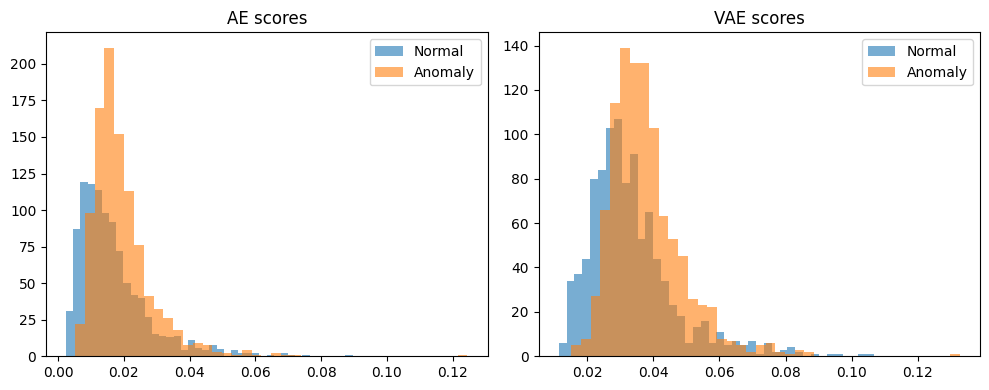

In [9]:
# 8) スコア分布の可視化（AE vs VAE）
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(ae_norm, bins=40, alpha=0.6, label="Normal")
plt.hist(ae_ano,  bins=40, alpha=0.6, label="Anomaly")
plt.title("AE scores"); plt.legend()

plt.subplot(1,2,2)
plt.hist(vae_norm, bins=40, alpha=0.6, label="Normal")
plt.hist(vae_ano,  bins=40, alpha=0.6, label="Anomaly")
plt.title("VAE scores"); plt.legend()
plt.tight_layout(); plt.show()


AE False Negatives FN count: 961


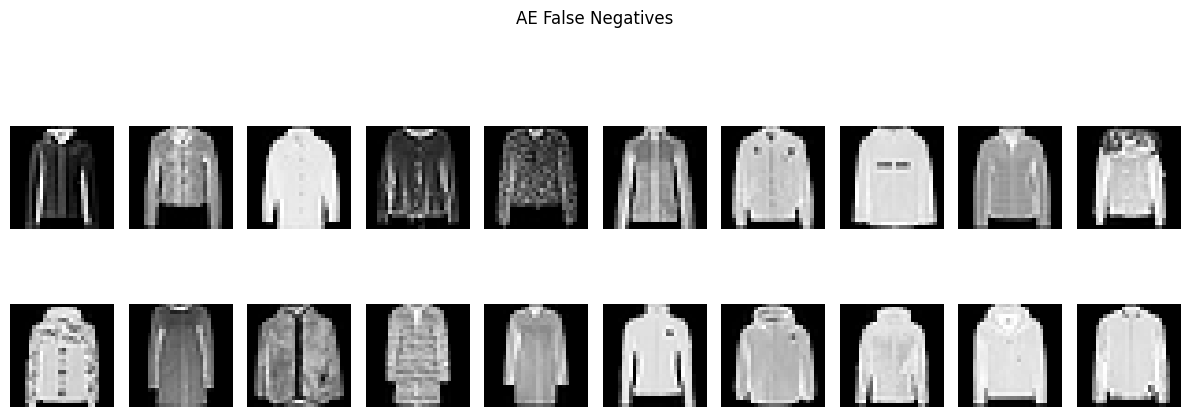

VAE False Negatives FN count: 964


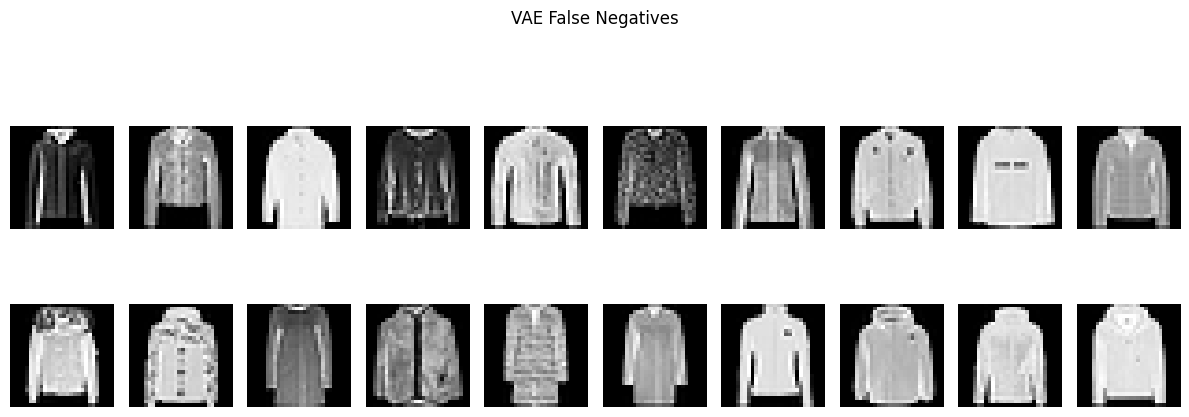

In [10]:
# 9) 誤検知の可視化（異常なのに正常と判定 = FN）
def show_false_negatives(scores_norm, scores_ano, x_norm, x_ano, title):
    thr = np.percentile(scores_norm, 95)
    preds_ano = (scores_ano > thr).astype(int)  # 1=異常と判定
    fn_idx = np.where(preds_ano==0)[0]          # 実際は異常なのに正常と判定
    print(title, "FN count:", len(fn_idx))
    n = min(20, len(fn_idx))
    if n==0:
        print("FNなし")
        return
    imgs = x_ano[fn_idx[:n]].cpu().view(-1,28,28).numpy()
    cols=10; rows=(n+cols-1)//cols
    fig,axes=plt.subplots(rows, cols, figsize=(12, 2.5*rows))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(imgs[i], cmap="gray"); axes[i].axis("off")
    for j in range(i+1,len(axes)): axes[j].axis("off")
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_false_negatives(ae_norm,  ae_ano,  x_test_norm, x_test_ano,  "AE False Negatives")
show_false_negatives(vae_norm, vae_ano, x_test_norm, x_test_ano,  "VAE False Negatives")
